# State Space Models



State Space Models (SSMs) are a new family of neural network architectures capable of modeling long-range dependencies in sequential data across various domains such as vision, audio, and language.
The main motivation behind these models is to address the **quadratic complexity** of Transformers and their inherent limitations regarding the effective **context size**.

In this lab, we will begin with a brief review of **state-space representations** in mechanics and control theory — the original inspiration for modern SSM architectures.
Next, we will move on to implementing a simple state-space layer, followed by a full implementation and training of an SSM based on the [**S4 (Structured State Space for Sequence Modeling)**](https://arxiv.org/pdf/2111.00396) framework, which represents a major breakthrough in efficiently learning long-range dependencies.

The following exercises are primarily based on the tutorial [*The Annotated S4*](https://srush.github.io/annotated-s4/), which has been adapted here to work entirely in **pure PyTorch**, without relying on **JAX** or **Flax** libraries.

You can check also other resources:

1. https://huggingface.co/blog/lbourdois/get-on-the-ssm-train
2. https://hazyresearch.stanford.edu/blog/2022-01-14-s4-3
3. https://www.youtube.com/watch?v=QJHA-PY8zDc
4. https://youtu.be/N6Piou4oYx8?si=CWbIX2FUUAApZHjw
5. https://github.com/state-spaces/s4

In [1]:
%matplotlib inline
from IPython.display import HTML

import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch.optim as optim

from torch.profiler import record_function, profile, ProfilerActivity

import wandb

wandb.login()  # Log in to your W&B account

torch.manual_seed(42)  # For reproducibility

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jrosa (deep-neural-network-course) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


## State-space representation in control engineering

Let us start from the fundamentals that should be familiar to anyone with a background in **Automation and Robotics**, but we will revisit them here in a structured and complementary way to build a solid foundation for understanding **state-space models**.

In **control engineering**, a **state-space representation** is a mathematical model of a **physical system** that describes its behavior in terms of internal **state variables**.
These state variables capture all the necessary information about the system’s dynamics at a given time, allowing us to predict its future evolution based on the current state and input.

It is defined by the following set of equations:

$$
\begin{aligned}
\dot{x}(t) &= \mathbf{A}x(t) + \mathbf{B}u(t) \\
y(t) &= \mathbf{C}x(t) + \mathbf{D}u(t)
\end{aligned}
$$

Here:

* $x(t)$ — the **state vector**, representing the internal state of the system
* $u(t)$ — the **input signal**, typically a 1-D control signal applied to the system
* $y(t)$ — the **output signal**
* $\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}$ — the **system matrices**, defining how the state and input evolve and influence the output

Below is a simple visualization of this model:

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab7_ssm/figures/ssm.png" alt="State Space Model Diagram" width="500"/>

> **Note:** Since the connection represented by matrix $\mathbf{D}$ is a simple *skip connection*, it is often omitted in research papers — both in visualizations and sometimes even during training.

This formulation provides a compact and general way to model **Linear Time-Invariant (LTI)** systems that map a 1-D input signal $u(t)$ to an N-dimensional latent state $x(t)$, before projecting it back to a 1-D output signal $y(t)$.
**During training, we will learn the parameters of the matrices $\mathbf{A}$, $\mathbf{B}$, $\mathbf{C}$, and $\mathbf{D}$.**

### Important Information!!!!

In **control engineering**, input and output signals are often **multidimensional**, representing multiple actuators, sensors, or system variables.
However, in **State Space Models** — and specifically in the **S4 (Structured State Space for Sequence Modeling)** architecture — the formulation is usually defined for **1-D sequences**.

As stated in the original S4 paper:

> “..., S4 defines a map from $\mathbb{R}^L \to \mathbb{R}^L$, i.e. a 1-D sequence map.
> Typically, DNNs operate on feature maps of size $H$ instead of 1.
> S4 handles multiple features by simply defining $H$ independent copies of itself, and then mixing the $H$ features with a position-wise linear layer for a total of $\mathcal{O}(H^2) + \mathcal{O}(HN)$ parameters per layer.”

In other words, if our input embeddings have a dimensionality of $H$, length $L$, and our state vector has a size of $N$, then we define **H independent State Space Models** with the following matrix dimensions:

* $\mathbf{A} \in \mathbb{R}^{N \times N}$
* $\mathbf{B} \in \mathbb{R}^{N \times 1}$
* $\mathbf{C} \in \mathbb{R}^{1 \times N}$
* $\mathbf{D} \in \mathbb{R}$

This results in $H$ parallel state-space modules:

* $\mathbf{A} \in \mathbb{R}^{H \times N \times N}$
* $\mathbf{B} \in \mathbb{R}^{H \times N \times 1}$
* $\mathbf{C} \in \mathbb{R}^{H \times 1 \times N}$
* $\mathbf{D} \in \mathbb{R}^{H}$

To utilize the functions defined at the beginning of this notebook, we will ensure that our implementation supports both **H-dimensional input features** and **batch (parallel) data processing** from the start.

#### Example – Pendulum

For a simple pendulum derived from Newton’s second law:

$$
m l^2 \ddot{\theta} + b \dot{\theta} + m g l \sin(\theta) = 0
$$

Defining the state variables:

$$
x_1 = \theta, \quad x_2 = \dot{\theta}
$$

gives the **nonlinear state–space form**:

$$
\begin{cases}
\dot{x}_1 = x_2 \\
\dot{x}_2 = -\dfrac{b}{m l^2} x_2 - \dfrac{g}{l} \sin(x_1)
\end{cases}
$$

For **small oscillations** ($\sin\theta \approx \theta$), the system becomes **linear**:

$$
\dot{x} = \mathbf{A}x + \mathbf{B}u, \quad y = \mathbf{C}x + \mathbf{D}u
$$

with:

$$
\mathbf{A} =
\begin{bmatrix}
0 & 1 \\
-\dfrac{g}{l} & -\dfrac{b}{m l^2}
\end{bmatrix}, \quad
\mathbf{B} =
\begin{bmatrix}
0 \\
\dfrac{1}{m l^2}
\end{bmatrix}, \quad
\mathbf{C} =
\begin{bmatrix}
1 & 0
\end{bmatrix}, \quad
\mathbf{D} = 0
$$

We can define function for generating such model below:

In [2]:
def example_pendulum(L, b, m):
    g = 9.81

    # State matrix A (2x2 for pendulum with 2 state variables)
    A = torch.tensor([
        [0, 1],
        [-g/L, -b/(m*L**2)]
    ], dtype=torch.float32)

    # Input matrix B (2x1)
    B = torch.tensor([
        [0],
        [1/(m*L**2)]
    ], dtype=torch.float32)

    # Output matrix C (1x2) - we observe the angle only
    C = torch.tensor([[1, 0]], dtype=torch.float32)

    # Add H dimension as first dimension (H=1 for this single pendulum)
    A = A.unsqueeze(0)  # Shape: (1, 2, 2)
    B = B.unsqueeze(0)  # Shape: (1, 2, 1)
    C = C.unsqueeze(0)  # Shape: (1, 1, 2)

    return A, B, C

# Test the function
A, B, C = example_pendulum(5, 10, 1)

print("Matrix A (shape =", A.shape, "):\n\n", A)
print("Matrix B (shape =", B.shape, "):\n\n", B)
print("Matrix C (shape =", C.shape, "):\n\n", C)

Matrix A (shape = torch.Size([1, 2, 2]) ):

 tensor([[[ 0.0000,  1.0000],
         [-1.9620, -0.4000]]])
Matrix B (shape = torch.Size([1, 2, 1]) ):

 tensor([[[0.0000],
         [0.0400]]])
Matrix C (shape = torch.Size([1, 1, 2]) ):

 tensor([[[1., 0.]]])


Nice — we now have our **State-Space Model**!
However, there is one issue: it defines the transitions between input and output as a **continuous-time function**, while we usually want a model that can process **discrete, sequence-to-sequence data**.

Without going into detailed derivations, the process of converting a continuous-time model into a discrete-time one is called **discretization**.

To discretize the continuous model, we can use the [**bilinear transform**](https://en.wikipedia.org/wiki/Bilinear_transform) (also known as the **Tustin method**), which is defined as:

$$
\begin{aligned}
\mathbf{\overline{A}} &= (\mathbf{I} - \tfrac{\Delta}{2}\mathbf{A})^{-1}(\mathbf{I} + \tfrac{\Delta}{2}\mathbf{A}) \\
\mathbf{\overline{B}} &= (\mathbf{I} - \tfrac{\Delta}{2}\mathbf{A})^{-1} \Delta \mathbf{B} \\
\mathbf{\overline{C}} &= \mathbf{C}
\end{aligned}
$$

Here, $\Delta$ represents the **sampling period (step)** — the time step between discrete samples — and the resulting matrices
$\mathbf{\overline{A}}, \mathbf{\overline{B}}, \mathbf{\overline{C}}$ form the **discrete-time state-space model**.

We will define function `discretize` that:
- initialize identity matrix I with dim H x N x N - use `.expand()`
- extend dim of `step` from H -> H x 1 x 1 - use .view()
- calculate disrecte A and B, using `torch.linalg.inv` and matrix multiplication `@`.

In [3]:
# Define `discretize` function that takes matrices A, B, C and sampling period step and return discrete A, B and C
def discretize(A, B, C, step):
    """
    Bilinear (Tustin) discretization.
    A:    (H,N,N)
    B:    (H,N,1)
    C:    (H,1,N)
    step: (H,)
    Returns Ab:(H,N,N), Bb:(H,N,1), Cb:(H,1,N)
    """
    assert A.dim() == 3, "Matrix A must be (H, N, N)"

    H, N, _ = A.shape
    I = torch.eye(N, device=A.device, dtype=A.dtype).expand(H, N, N)  # (H,N,N)
    step = step.view(H, 1, 1)                                  # (H,1,1)

    BL = torch.linalg.inv(I - (step / 2.0) * A)                  # (H,N,N)
    Ab = BL @ (I + (step / 2.0) * A)                             # (H,N,N)
    Bb = BL @ (step * B)                                       # (H,N,1)
    return Ab, Bb, C

step = torch.tensor([0.01])
Ab, Bb, C = discretize(A, B, C, step)

print("Matrix Ab:\n\n", Ab)
print("Matrix Bb:\n\n", Bb)
print("Matrix C:\n\n", C)

Matrix Ab:

 tensor([[[ 0.9999,  0.0100],
         [-0.0196,  0.9959]]])
Matrix Bb:

 tensor([[[1.9959e-06],
         [3.9918e-04]]])
Matrix C:

 tensor([[[1., 0.]]])


### Important Information!!!

This equation is now a **sequence-to-sequence** map,
i.e. it maps discrete inputs $u_k$ to outputs $y_k$, instead of defining a continuous function-to-function relation.
It can be written as:

$$
\begin{aligned}
x_k &= \mathbf{\overline{A}} x_{k-1} + \mathbf{\overline{B}} u_k \\
y_k &= \mathbf{\overline{C}} x_k
\end{aligned}
$$

As the authors of the S4 paper stated:

> “Equation (above) is now a sequence-to-sequence map
> $u_k \to y_k$ instead of function-to-function.
> Moreover, the state equation is now a recurrence in $x_k$,
> allowing the discrete SSM to be computed like an RNN.
> Concretely, $x_k \in \mathbb{R}^N$ can be viewed as a hidden state with transition matrix $\mathbf{A}$.”

**Yes — our discretized state-space model behaves just like a Recurrent Neural Network (RNN)!**


We can define function `scan_SSM` that will takes our disretized SSM, input vector $u$ and initial state $x_0$ that will iterate over $L$ timestamps:
- get sequence length `L` and init first state `x` as `x0`
- squeeze matrices B and C to reduce unnecessary dimensions
- prepare list `ys` for outputs for each iteration
- iterate over sequence lenght:
    - calculate `x` as `Ab`*`x` (we can use [torch.einsum](https://docs.pytorch.org/docs/stable/generated/torch.einsum.html) for easy operation along specified dimensions)
    - get input `u_t` for timestamp `t`
    - calculate `Bb` * `u_t` (we need to unsqueeze dimensions) and add to `x`
    - calculate `yt = Cb * x_t+1` (again we can use [torch.einsum](https://docs.pytorch.org/docs/stable/generated/torch.einsum.html))
    - append `yt` to list `ys`
- stack outputs `ys` and returns last `x` with stacked `y`

In [4]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    """
    RNN scan over time.
    Ab: (H,N,N)
    Bb: (H,N,1)
    Cb: (H,1,N)
    u:  (B,L,H)
    x0: (B,H,N)

    Returns:
      x_T: (B,H,N)
      y:   (B,L,H)
    """
    assert (Ab.dim() == 3) and (Bb.dim() == 3) and (Cb.dim() == 3), \
      f"Dim of State Space matrices must be 3, is Ab = {Ab.dim()}, Bb = {Bb.dim()}, Cb = {Cb.dim()}"

    assert (u.dim() == 3)  and (x0.dim() == 3), \
      f"Dim of input and state vectors must be 3, is u = {u.dim()}, x0 = {x0.dim()}"

    B, L, H = u.shape
    x = x0                                      # init first state          (B,H,N)
    Bb_s = Bb.squeeze(-1)                      # squeeze Bb dim (H,N,1) -> (H,N)
    Cb_s = Cb.squeeze(1)                       # squeeze Cb dim (H,1,N) -> (H,N)
    ys = []
    for t in range(L):                          # iterate over len sequence
        x = torch.einsum('hnm,bhn->bhm', Ab, x)                # Ab * x_t                      (H,N,N)*(B,H,N)->(B,H,N)
        u_t = u[:, t, :]                                       # get input u_t in timestamp t  (B,H)
        x = x + Bb_s.unsqueeze(0)*u_t.unsqueeze(-1)            # x_t+1 = Ab * x_t + Bb * u_t   (B,H,N)+(1,H,N)*(B,H,1)->(B,H,N)
        y_t = torch.einsum('hn,bhn->bh', Cb_s, x)              # yt = Cb * x_t+1               (H,N)*(B,H,N)->(B,H)
        ys.append(y_t.real)                                    # append y_t.real to ys (real part will be necessary in S4)
    y = torch.stack(ys, dim=1)                                 # stack ys                      (B,L,H)
    return x, y

We can fuse both `discretize` and `scan_SSM` into a single function called `run_SSM`, which takes the continuous matrices `A`, `B`, and `C`, along with the input vector `u`, and returns only the output `y` produced by the `scan_SSM` function.

For simplicity, we will define the step size as `1.0 / L` for each of the `H` dimensions, and initialize the state `x0` as a zero matrix of shape `(B, H, N)`.

**During training, the step size is also treated as a learnable parameter!!!**

In [5]:
def run_SSM(A, B, C, u):
    """
    Run a full State Space Model (SSM) sequence.

    Combines continuous-to-discrete conversion (discretization)
    and sequential processing (scan) into a single function.

    Args:
        A: Continuous-time transition matrix, shape (H, N, N)
        B: Continuous-time input matrix, shape (H, N, 1)
        C: Output matrix, shape (H, 1, N)
        u: Input sequence tensor, shape (B, L, H)

    Returns:
        y: Output sequence tensor, shape (B, L, H)
    """
    Bsz, L, H = u.shape
    N = A.shape[-1]

    step = torch.full((A.shape[0],), 1.0 / L, dtype=A.dtype, device=A.device)   # (H)
    Ab, Bb, Cb = discretize(A, B, C, step=step)

    x0 = torch.zeros((Bsz, H, N), dtype=A.dtype, device=A.device)               # (B,H,N)
    return scan_SSM(Ab, Bb, Cb, u.to(A.dtype), x0)[1]                           # (B, L, H)

To test if everything is working for now, we will visualise our Pendulum State Space Model with example torque sinusoidal input.

In [6]:
def example_SSM():
    ssm = example_pendulum(L=1.0, b=0.2, m=1.0)

    L = 100
    step = 1 / L
    ks = torch.arange(L)
    ts = torch.linspace(0, 1 - 1/L, steps=L, dtype=torch.float32)

    # Input torque
    def example_torque(t):
        x = torch.sin(2 * torch.pi * 1.5 * t)
        x = x * (x > 0.0) * 5
        return x[None, :, None]

    u = example_torque(ts)
    y = run_SSM(*ssm, u)

    u = u.squeeze()
    y = y.squeeze()

    ts = ts.detach().cpu().numpy()
    u = u.detach().cpu().numpy()
    y = y.detach().cpu().numpy()

    # --- Figure setup ---
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])
    ax_pendulum = fig.add_subplot(gs[0], aspect='equal')
    ax_torque = fig.add_subplot(gs[1])
    ax_angle = fig.add_subplot(gs[2])

    # Pendulum line setup
    pendulum_line, = ax_pendulum.plot([], [], 'o-', lw=3, color='blue')
    ax_pendulum.set_xlim(-1.2, 1.2)
    ax_pendulum.set_ylim(-1.2, 0.2)
    ax_pendulum.set_xlabel("x")
    ax_pendulum.set_ylabel("y")
    ax_pendulum.grid(True)

    # Torque plot
    ax_torque.set_title("Input Torque τ(t)")
    ax_torque.plot(ts, u, color='red', alpha=0.4)
    torque_dot, = ax_torque.plot([], [], 'ro', markersize=6)
    ax_torque.set_xlim(ts[0], ts[-1])
    ax_torque.set_ylim(u.min() - 0.1, u.max() + 0.1)
    ax_torque.grid(True)

    # Angle plot
    ax_angle.set_title("Pendulum Angle θ(t)")
    ax_angle.plot(ts, y, color='blue', alpha=0.4)
    angle_dot, = ax_angle.plot([], [], 'bo', markersize=6)
    ax_angle.set_xlim(ts[0], ts[-1])
    ax_angle.set_ylim(y.min() - 0.1, y.max() + 0.1)
    ax_angle.grid(True)
    ax_angle.set_xlabel("Time [s]")

    L_pend = 1.0

    def update(frame):
        theta = y[frame].item()
        x = L_pend * math.sin(theta)
        y_p = -L_pend * math.cos(theta)
        pendulum_line.set_data([0, x], [0, y_p])

        t_val = ts[frame]
        u_val = u[frame]
        y_val = y[frame]

        torque_dot.set_data([t_val], [u_val])
        angle_dot.set_data([t_val], [y_val])

        return pendulum_line, torque_dot, angle_dot

    ani = animation.FuncAnimation(
        fig, update, frames=len(ts), interval=100, blit=True, repeat=False
    )

    plt.close(fig)
    return HTML(ani.to_jshtml())

# Run
example_SSM()

Output hidden; open in https://colab.research.google.com to view.

## State-Space Models

For now, everything should work.
But someone might ask:

> “Okay, that’s cool — we have SSMs that behave like RNNs, but is that really all? Why can’t we just use well-known models like LSTMs or GRUs?”

That’s a great question — and there’s one **very important difference**.

During **inference**, SSMs indeed operate similarly to RNNs using the recurrence formula.
However, during **training**, efficiency and **parallelism** are crucial.
RNNs process data *sequentially*, step by step, which limits parallelization.
In contrast, **State Space Models** allow us to express the same recurrence using **discrete convolutions**, enabling **parallel computation** across the entire sequence.

As the authors explain in the paper:

> “The recurrent SSM is not practical for training on modern hardware
> due to its sequential nature. Instead, there is a well-known connection
> between linear time-invariant (LTI) SSMs and continuous convolutions.
> Correspondingly, the recurrent SSM can actually be written as a discrete convolution.
>
> For simplicity, let the initial state be $x_{-1} = 0$. Then unrolling explicitly yields:
>
> $$
> \begin{aligned}
> x_0 &= \mathbf{\overline{B}} u_0 \\
> x_1 &= \mathbf{\overline{A}} \mathbf{\overline{B}} u_0 + \mathbf{\overline{B}} u_1 \\
> x_2 &= \mathbf{\overline{A}}^2 \mathbf{\overline{B}} u_0 + \mathbf{\overline{A}} \mathbf{\overline{B}} u_1 + \mathbf{\overline{B}} u_2 + \dots \\
> y_0 &= \mathbf{\overline{C}} \mathbf{\overline{B}} u_0 \\
> y_1 &= \mathbf{\overline{C}} \mathbf{\overline{A}} \mathbf{\overline{B}} u_0 + \mathbf{\overline{C}} \mathbf{\overline{B}} u_1 \\
> y_2 &= \mathbf{\overline{C}} \mathbf{\overline{A}}^2 \mathbf{\overline{B}} u_0 + \mathbf{\overline{C}} \mathbf{\overline{A}} \mathbf{\overline{B}} u_1 + \mathbf{\overline{C}} \mathbf{\overline{B}} u_2 + \dots
> \end{aligned}
> $$
>
> This can be vectorized into a convolution with an explicit formula for the convolution kernel:
>
> $$
> \begin{aligned}
> y_k &= \mathbf{\overline{C}} \mathbf{\overline{A}}^k \mathbf{\overline{B}} u_0
> + \mathbf{\overline{C}} \mathbf{\overline{A}}^{k-1} \mathbf{\overline{B}} u_1
> + \dots
> + \mathbf{\overline{C}} \mathbf{\overline{A}} \mathbf{\overline{B}} u_{k-1}
> + \mathbf{\overline{C}} \mathbf{\overline{B}} u_k \\
> y &= \mathbf{\overline{K}} \ast u
> \end{aligned}
> $$
>
> where
>
> $$
> \mathbf{\overline{K}} \in \mathbb{R}^L =
> (\mathbf{\overline{C}}\mathbf{\overline{B}},
> \mathbf{\overline{C}}\mathbf{\overline{A}}\mathbf{\overline{B}},
> \dots,
> \mathbf{\overline{C}}\mathbf{\overline{A}}^{L-1}\mathbf{\overline{B}})
> $$
>
> We call $\mathbf{\overline{K}}$ the **SSM convolution kernel** or **filter**.

Note that this is a *giant* filter — it spans the **entire sequence length**!


#### To remember!

A key feature of the State Space Model (SSM) is that it has three equivalent representations, allowing it to be viewed — and computed — as a continuous-time, recurrent, or convolutional model.
Moreover, these representations can be interchanged depending on which properties are most useful for a given application.

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab7_ssm/figures/forms.png" alt="Different forms of SSMs" width="800px"/>

While we started from the continuous-time representation, we will not use it directly since we operate on sequence-to-sequence data.
The recurrent representation is primarily used during inference, whereas the convolutional form is preferred during training for its parallel efficiency.



Define a function `conv_kernel` that calculates the convolution kernel from the **discretized** matrices `A`, `B`, and `C` for a sequence of length `L` (**remember the H dimension!**).

Steps to implement:

* Prepare an identity matrix `I` of shape `(H, N, N)` that will serve as the initial power matrix `Al` (i.e. ( A^0 = I )).
* Squeeze matrices `B` and `C` to shapes `(H, N)`.
* Iterate over the sequence length `L`:

  * Compute the current kernel element as
    ( $K_l = C_b \cdot A_l \cdot B_b$ ),
    where `(H) = (H, N) * (H, N, N) * (H, N)` — use `torch.einsum`.
  * Append each computed value `K_l` to the list `Ks`.
  * Update the power matrix as
    ( $A_l = A_l \cdot A_b$ )
    with `torch.einsum`.
* Stack all kernel elements into a tensor `K` of shape `(L, H)`.
* Return `K.real` if the tensor is complex (i.e. `torch.is_floating_point(K)` is `False`) — this step is important for the later **S4** implementation, which requires real-valued kernels.


In [7]:
def conv_kernel(Ab, Bb, Cb, L):
    """
    Compute kernels K[l,h] = C_h Ab_h^l B_h for all channels h=1..H.
    Ab: (H,N,N)
    Bb: (H,N,1)
    Cb: (H,1,N)

    Returns:
      K: (L, H)
    """
    H, N, _ = Ab.shape
    I = torch.eye(N, device=Ab.device, dtype=Ab.dtype).expand(H, N, N)
    Al = I.clone()                      # (H,N,N)
    Ks = []

    # Pre-squeeze for efficient einsum
    Bb_s = Bb.squeeze(-1)               # (H,N)
    Cb_s = Cb.squeeze(1)                # (H,N)

    for _ in range(L):
        # K_l[h] = Cb_s[h] @ Al[h] @ Bb_s[h] -> (H)
        K_l = torch.einsum('hn,hnm,hm->h', Cb_s, Al, Bb_s)
        Ks.append(K_l)
        Al = torch.einsum('hnm,hmk->hnk', Al, Ab)  # Al = Al @ Ab, batched over H

    K = torch.stack(Ks, dim=0)          # (L,H)
    return K if torch.is_floating_point(K) else K.real

Now we can define a function that takes an input sequence tensor and the corresponding convolution kernel.
While we could perform this operation using a standard `Conv1d`, there is an additional mathematical trick:
we can compute the result using **fast convolution algorithms** by leveraging the **Fast Fourier Transform (FFT)** based on the [**circular discrete convolution**](https://en.wikipedia.org/wiki/Convolution#Circular_discrete_convolution) theorem.

In simple terms, this means we first compute the FFT of both the (padded) input sequence and the kernel, perform an elementwise multiplication in the frequency domain, and then apply the inverse FFT to return to the time domain.
To use this theorem for **non-circular** convolutions (as in our case), we pad the input and kernel with zeros — and later remove the extra padding from the output.

---

Define a function `causal_convolution` that performs a **causal convolution** for each feature dimension (head `H`) and batch `B`, using either a **direct** or **FFT-based** implementation.

### Function Inputs

* `u`: input sequence tensor of shape `(B, L, H)`.
* `K`: causal convolution kernel of shape `(L, H)`.
* `use_fft`: boolean flag that determines whether to use the **FFT-based** implementation (default `True`).

---

### If `use_fft=False` (Direct Convolution)

1. **Rearrange the input** to match the expected shape for `torch.nn.functional.conv1d`:
   ( $u \rightarrow (B, H, L)$ )
2. **Prepare the kernel** by transposing and unsqueezing to shape `(H, 1, L)`.
3. **Perform 1D convolution** using `F.conv1d` with `groups=H` to apply independent filters for each head:

   * Flip the kernel along the time dimension to preserve *causality*.
   * Use `padding=L-1` to maintain sequence length.
4. **Crop** the output to the first `L` time steps and **permute back** to shape `(B, L, H)`.

---

### If `use_fft=True` (FFT-Based Convolution)

1. **Permute** the input to `(B, H, L)` for frequency-domain processing.
2. **Pad** both the input and the **transposed** kernel to length `2L` along the time axis to avoid circular convolution artifacts.
3. **Compute the FFT** of the padded input and kernel:

   * `Ud = torch.fft.rfft(u_pad)` → frequency-domain representation of the input.
   * `Kd = torch.fft.rfft(K_pad)` → frequency-domain representation of the kernel (unsqueezed to match batch dimensions).
4. **Multiply** them elementwise in the frequency domain:
   ( $Y_d = U_d \cdot K_d$ )
5. **Compute the inverse FFT** to return to the time domain:
   ( $y_{\text{pad}} = \text{irfft}(Y_d)$ )
6. **Truncate** the output to the first `L` samples and **permute back** to `(B, L, H)`.

---

**Notes:**

* The FFT-based implementation is significantly faster for long sequences (`L` large), reducing complexity from **O(L²)** to **O(L log L)**.
* Both implementations preserve *causality* — meaning each output sample depends only on the current and past input values, never on future ones.


In [8]:
def causal_convolution(u, K, use_fft=True):
    """
    Causal convolution per head (H) and batch (B).

    Args:
        u: (B, L, H) real or complex tensor (input sequence)
        K: (L, H) real or complex tensor (causal filter)
        use_fft: bool, if True uses FFT-based convolution (default True)

    Returns:
        y: (B, L, H) same type as u
    """
    B, L, H = u.shape
    assert K.shape == (L, H), f"Expected K shape (L, H), got {K.shape}"

    if not use_fft:
        # --- Direct convolution (slower for long L) ---
        # Rearrange to (B, H, L) for conv1d
        u_bhl = u.permute(0, 2, 1)                  # (B, H, L)
        K_hl = K.permute(1, 0).unsqueeze(1)         # (H, 1, L)

        # Flip kernel for causality and use groups for independent H channels
        K_flipped = torch.flip(K_hl, dims=[-1])
        y_full = F.conv1d(u_bhl, K_flipped, padding=L-1, groups=H)
        y = y_full[:, :, :L]                         # (B, H, L)
        return y.permute(0, 2, 1)                   # (B, L, H)
    else:
        # --- FFT-based convolution ---
        u_bhl = u.permute(0, 2, 1)                  # (B, H, L)
        u_pad = F.pad(u_bhl, (0, L))                # (B, H, 2L)
        K_pad = F.pad(K.permute(1, 0), (0, L))      # (H, 2L)

        Ud = torch.fft.rfft(u_pad, dim=-1)          # (B, H, F)
        Kd = torch.fft.rfft(K_pad, dim=-1).unsqueeze(0)  # (1, H, F)
        Yd = Ud * Kd                                # (B, H, F)
        y_pad = torch.fft.irfft(Yd, dim=-1)         # (B, H, 2L)
        y = y_pad[:, :, :L]                         # (B, H, L)
        return y.permute(0, 2, 1)                   # (B, L, H)

We will now test whether our implementations are correct by generating a **random State Space Model (SSM)**, a random **input sequence**, and then comparing the outputs obtained from three computation modes:

1. **RNN mode** – sequential computation using the recurrent SSM formulation.
2. **CNN mode** – convolution-based computation using the direct (non-FFT) convolution.
3. **CNN (FFT) mode** – convolution-based computation using the **FFT-accelerated** convolution.

For each mode, we will compute the **absolute maximum difference** between the outputs to verify that all implementations produce equivalent results within numerical precision (values should be in $10^{-7}$).


In [9]:
def random_SSM(N: int, H: int = 1):
    """
    Create random SSM matrices A, B, C with uniform(0,1) values.
    Returns torch tensors.
    """
    A = torch.rand((H, N, N))
    B = torch.rand((H, N, 1))
    C = torch.rand((H, 1, N))
    return A, B, C

B = 1
H = 2
N = 4
L = 16
step = torch.tensor([1 / L]*H)
u = torch.randn((B, L, H))

ssm = random_SSM(N, H)
ssmb = discretize(*ssm, step=step)
K = conv_kernel(*ssmb, L)

rec = run_SSM(*ssm, u)
conv = causal_convolution(u, K, use_fft=False)
conv_fft = causal_convolution(u, K)

print("rec - conv:", (rec.ravel() - conv.ravel()).abs().max().item())
print("rec - conv_fft:", (rec.ravel() - conv_fft.ravel()).abs().max().item())
print("conv - conv_fft:", (conv.ravel() - conv_fft.ravel()).abs().max().item())

rec - conv: 0.15052461624145508
rec - conv_fft: 0.15052473545074463
conv - conv_fft: 3.8743019104003906e-07


We will also measure the execution time of each mode to compare their computational efficiency for long sequence:

In [10]:
B = 1
H = 2
N = 4
L = 10_000
step = torch.tensor([1 / L]*H)
u = torch.randn((B, L, H))

ssm = random_SSM(N, H)
ssmb = discretize(*ssm, step=step)
K = conv_kernel(*ssmb, L)

t0 = time.time()
rec = run_SSM(*ssm, u)
t1 = time.time()
conv = causal_convolution(u, K, use_fft=False)
t2 = time.time()
conv_fft = causal_convolution(u, K)
t3 = time.time()

print(f"RNN recursion time: {t1 - t0:.4f} s")
print(f"Direct conv time:   {t2 - t1:.4f} s")
print(f"FFT conv time:      {t3 - t2:.4f} s")

RNN recursion time: 0.8068 s
Direct conv time:   3.9904 s
FFT conv time:      0.0069 s


Before defining the SSM layer, we first create a small utility function to initialize the logarithmic time-step parameter.

The function `log_step_initializer` initializes the logarithmic time-step parameter `log_step` uniformly in the logarithmic domain between `dt_min` and `dt_max`.
This ensures that the actual step size

$\Delta = e^{\text{log\_step}}$

is distributed across a reasonable dynamic range for stable training.


In [11]:
# -------------------------
# Log step initializer
# -------------------------

def log_step_initializer(param, dt_min=1e-3, dt_max=1e-1):
    """
    Uniform log-step initializer (in-place).
    """
    with torch.no_grad():
        low, high = np.log(dt_min), np.log(dt_max)
        param.uniform_(low, high)
    return param

#### SSM Layer

Next, we define the main **State Space Model (SSM) layer** — a PyTorch module that can operate in both **recurrent (RNN)** and **convolutional (CNN)** modes.
It maintains learnable parameters for the SSM matrices and supports fast inference and training through discretization and FFT-based convolution.

**Main components:**

* `A`, `B`, `C`, `D`: learnable SSM parameters for each feature dimension (head `H`).
* `log_step`: learnable logarithmic time-step parameter.
* `cache`: buffer used to store the last hidden state during recurrent (decode) mode.

##### Forward Pass Logic

1. **Discretization step** –
   * Convert continuous-time matrices (`A`, `B`, `C`) into discrete-time ones (`Ab`, `Bb`, `Cb`) using the exponential of `log_step`.

2. **CNN mode (training)** –

   * Compute the convolution kernel using `conv_kernel`.
   * Perform a causal convolution with FFT acceleration via `causal_convolution`.
   * Add the skip connection term `D * u`.

3. **RNN mode (inference)** –

   * Compute the sequence iteratively using `scan_SSM`.
   * Update the internal hidden state (`cache`) - remeber to `.detach()`.
   * Add the skip connection term `D * u`.

In [12]:
# -------------------------
# SSM Layer
# -------------------------
import torch
import torch.nn as nn
import numpy as np
from torch.autograd.profiler import record_function

class SSMLayer(nn.Module):
    def __init__(self, N: int, H: int, l_max: int, decode: bool = False):
        super().__init__()
        self.N = N
        self.H = H
        self.l_max = l_max
        self.decode = decode

        # Parameters
        self.A = nn.Parameter(torch.randn(H, N, N) * (1.0 / np.sqrt(N)))        #  (H,N,N)
        self.B = nn.Parameter(torch.randn(H, N, 1) * (1.0 / np.sqrt(N)))        #  (H,N,1)
        self.C = nn.Parameter(torch.randn(H, 1, N) * (1.0 / np.sqrt(N)))        #  (H,1,N)
        self.D = nn.Parameter(torch.ones(H))                                    #  (H)

        # Time step
        self.log_step = nn.Parameter(torch.empty(H))                            #  (H)
        log_step_initializer(self.log_step)

        # RNN cache
        self.register_buffer("cache", torch.zeros(1, H, N))                     #  (1,H,N)

    def forward(self, u):
        """
        u: (B, L, H) input tensor
        """
        with record_function("ssm/exp_step"):
            step = torch.exp(self.log_step)  # (H,)

        with record_function("ssm/discretize"):
            Ab, Bb, Cb = discretize(self.A, self.B, self.C, step)

        if not self.decode:
            # CNN mode (training)
            with record_function("ssm/conv_kernel"):
                K = conv_kernel(Ab, Bb, Cb, self.l_max)

            with record_function("ssm/causal_convolution"):
                y = causal_convolution(u, K, use_fft=True)
            return y + self.D * u
        else:
            # RNN mode (inference)
            x_T, y_s = scan_SSM(Ab, Bb, Cb, u, self.cache)
            self.cache = x_T.detach()  # Detach to avoid backprop through time during inference
            return y_s + self.D * u

Now, let's **test our SSM layer** in both modes — with `decode = False` (CNN mode) and `decode = True` (RNN mode) — using **random batched input data**.


In [13]:
# -------------------------
# Example usage
# -------------------------
B = 2
N = 4
H = 16
L = 32

layer = SSMLayer(N=N, H=H, l_max=L, decode=False).to(device)
u = torch.randn(B, L, H).to(device)

# CNN mode
y_cnn = layer(u)
print("Output (CNN mode):", y_cnn.shape)
print(y_cnn[0, :, 0])

# Switch to RNN mode
layer.decode = True
y_rnn = layer(u)
print("Output (RNN mode):", y_rnn.shape)
print(y_rnn[0, :, 0])

print("diff:", (y_cnn.ravel() - y_rnn.ravel()).abs().max().item())

Output (CNN mode): torch.Size([2, 32, 16])
tensor([-1.2654, -0.6779,  1.5662,  1.1061, -0.2771, -0.6618, -0.2125,  0.8374,
         0.3840, -0.1327, -1.0907, -0.0781, -0.8339,  1.5517,  1.0709, -0.4031,
        -0.7545,  2.4131,  0.0249,  1.4240, -2.2398, -0.8293, -0.1149,  0.0307,
        -0.3049, -0.8689, -0.7958, -0.5448, -0.2936, -0.8814, -1.9275,  0.3841],
       device='cuda:0', grad_fn=<SelectBackward0>)
Output (RNN mode): torch.Size([2, 32, 16])
tensor([-1.2654, -0.6779,  1.5664,  1.1063, -0.2770, -0.6617, -0.2124,  0.8376,
         0.3841, -0.1326, -1.0907, -0.0780, -0.8338,  1.5519,  1.0710, -0.4030,
        -0.7544,  2.4132,  0.0249,  1.4239, -2.2401, -0.8297, -0.1153,  0.0303,
        -0.3054, -0.8694, -0.7963, -0.5453, -0.2940, -0.8817, -1.9277,  0.3841],
       device='cuda:0', grad_fn=<SelectBackward0>)
diff: 0.20832061767578125


If everything is correct, we should observe a difference in the range of approximately (10^{-7}).

So… do we already have a fully functional SSM that we can directly train on our dataset?
That would be **too easy**, don’t you think? 😄

Let’s push it further and **test our model on a longer sequence**, evaluating both its **runtime performance** and **output consistency**.

We’ll use **PyTorch Profiler** with `record_function` to measure execution time, and as an example, we’ll process an input sequence of length **784** — which corresponds to the number of pixels in an MNIST image (so it’s not a *very* long sequence, but long enough to illustrate performance differences).


In [14]:
# -------------------------
# Example usage
# -------------------------
B = 2
N = 16
H = 32
L = 784

layer = SSMLayer(N=N, H=H, l_max=L, decode=False)
u = torch.randn(B, L, H)

with profile(activities=[ProfilerActivity.CPU],
        record_shapes=True, profile_memory=True, with_stack=False) as prof:
    outputs = layer(u)

print("\n=== INFERENCE (CNN mode) ===")
print(prof.key_averages(group_by_input_shape=False)
    .table("self_cpu_time_total",
            row_limit=40))


=== INFERENCE (CNN mode) ===
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               ssm/conv_kernel        37.21%     192.398ms        91.95%     475.381ms     475.381ms      26.13 MB    -131.00 KB             1  
                     aten::bmm        15.02%      77.653ms        15.18%      78.487ms      33.342us      26.16 MB      26.16 MB          2354  
                  aten::einsum        14.65%      75.757ms        54.53%     281.907ms     179.787us      26.13 MB           0 B          1568  
                 aten::permute        11.26%      58.191ms        13.04%      67.421ms       6.139us

In the profiler table, the most important column is **CPU total**, and we should focus on the following rows:
`ssm/conv_kernel`, `ssm/discretize`, and `ssm/causal_convolution`.

In my case, the **discretization** and **causal convolution** steps each take **less than 1 ms**, which is extremely fast thanks to the use of **FFT-based convolution**.

However, we haven’t yet discussed the cost of **computing the large convolution kernel** itself — and this step is **much slower**.
In fact, generating the kernel now takes **over 193 ms**, which is **193 times slower** than performing the convolution!


But that is not all. Lets check the outputs for this longer sequence:

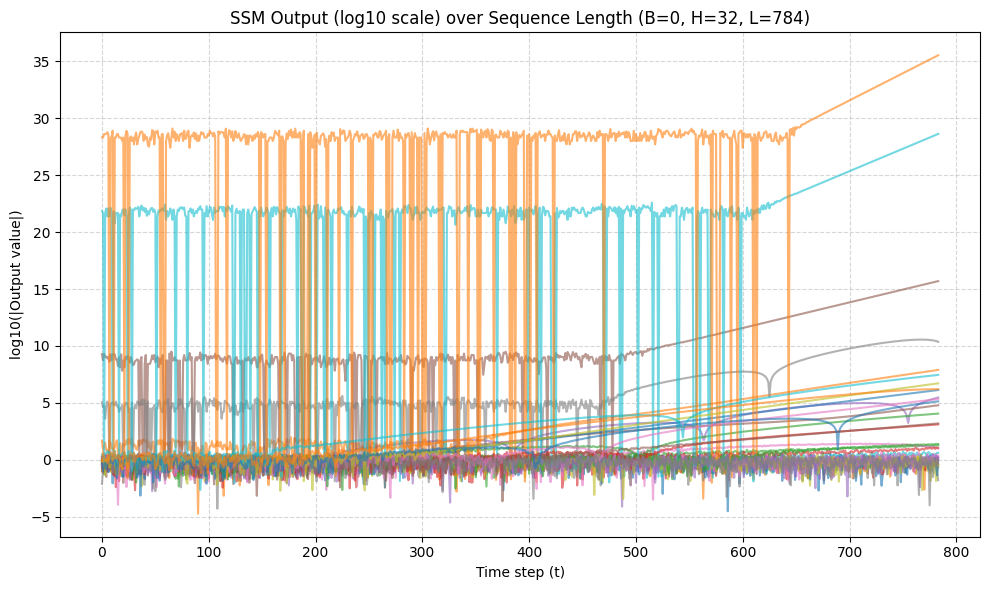

In [15]:
# -------------------------
# Example usage
# -------------------------
B = 2
N = 16
H = 32
L = 784

layer = SSMLayer(N=N, H=H, l_max=L, decode=False)
u = torch.randn(B, L, H)

outputs = layer(u)

y = outputs[0].detach().cpu().numpy()
y_abs = np.abs(y) + 1e-8

plt.figure(figsize=(10, 6))
for h in range(H):
    plt.plot(np.log10(y_abs[:, h]), alpha=0.6, label=f'H={h}' if h < 10 else None)

plt.title(f"SSM Output (log10 scale) over Sequence Length (B=0, H={H}, L={L})")
plt.xlabel("Time step (t)")
plt.ylabel("log10(|Output value|)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

What is important to notice in this plot is that the **Y-axis is in logarithmic scale**, and some sequences reach extremely large values — up to $10^{15}$!

But why does this happen?
As the authors of the paper explain:

> “Prior work found that the basic SSM actually performs very poorly in practice. Intuitively, one explanation is that linear first-order ODEs solve to an exponential function, and thus may suffer from gradients scaling exponentially with sequence length (i.e., the vanishing/exploding gradients problem).”

This explanation is certainly true — but there is an even more fundamental reason behind it. Recall that we are working with **state-space models**, and not all of them are **stable**. The stability of such a system is determined by the **matrix $\mathbf{A}$**.

A system is **asymptotically stable** if and only if **all eigenvalues of $\mathbf{A}$** have **strictly negative real parts**:

$$
\Re(\lambda_i(\mathbf{A})) < 0 \quad \forall i
$$

Therefore, if we generate the matrices $\mathbf{A}$ randomly, there is a high probability that some of the $H$ dimensions in our model will correspond to **unstable systems**, leading to exponential growth in the outputs.


Now, we will focus on addressing both of these problems — ensuring system stability and implementing fast convolution kernel generation, as introduced in the S4 paper.

## SS4

Let’s start by ensuring **system stability**. As stated in the paper:

> [Prior work](https://arxiv.org/abs/2008.07669) found that the basic SSM actually performs very poorly in practice.
> Intuitively, one explanation is that they suffer from gradients scaling exponentially with sequence length
> (i.e., the vanishing/exploding gradients problem).
> To address this issue, previous work developed the **HiPPO theory** of continuous-time memorization.
>
> HiPPO specifies a class of matrices $\mathbf{A} \in \mathbb{R}^{N \times N}$ that, when incorporated,
> allow the state $x(t)$ to memorize the history of the input $u(t)$.
> The most important matrix in this class is defined as the **HiPPO matrix**:
>
> $$
> \begin{aligned}
> \textbf{(HiPPO Matrix)} \qquad
> \mathbf{A}_{nk}
> = -
> \begin{cases}
> \sqrt{(2n+1)(2k+1)} & \text{if } n > k \\
> n+1 & \text{if } n = k \\
> 0 & \text{if } n < k
> \end{cases}
> \end{aligned}
> $$
>
> Previous work found that simply replacing a random state matrix $\mathbf{A}$
> with the HiPPO matrix improved performance on the **sequential MNIST** benchmark
> from **60%** to **98%** accuracy.

Although it was not explicitly mentioned in the original paper or tutorial,
this matrix has one very important property:
its **eigenvalues** are equal to the values on its **diagonal**,
and due to the leading negative sign, they are always **less than zero**.
This makes the model **stable**, and that is the key point to remember.

---

Another important aspect of the HiPPO formulation is that it forces the state vector $x(t)$
to **approximate the recent history** of the input function using **orthogonal polynomials**,
specifically [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials).

This means:

* Each component of $x(t)$ represents a **weighted summary** of past inputs.
* **New information** smoothly replaces older information.
* The model naturally encodes **long-term memory**.

---

**In short:**
We use **HiPPO** in SSMs because it provides a **mathematically grounded**,
**stable**, and **memory-efficient** way to design the continuous-time dynamics of the model.

Define function that generate HiPPO matrix:

In [16]:
def make_HiPPO(N, device=None, dtype=torch.float32):
    # Create indices for the matrix
    n = torch.arange(N, device=device, dtype=dtype)
    k = torch.arange(N, device=device, dtype=dtype)

    # Create coordinate grids
    n_grid, k_grid = torch.meshgrid(n, k, indexing='ij')

    # Initialize the matrix with zeros
    A = torch.zeros((N, N), device=device, dtype=dtype)

    # Fill the diagonal: A_{nn} = -(n+1)
    diag_mask = n_grid == k_grid
    A[diag_mask] = -(n_grid[diag_mask] + 1)

    # Fill the lower triangular part (n > k): A_{nk} = -sqrt((2n+1)(2k+1))
    lower_mask = n_grid > k_grid
    A[lower_mask] = -torch.sqrt((2*n_grid[lower_mask] + 1) * (2*k_grid[lower_mask] + 1))

    return A

# Test the function
print(make_HiPPO(N=5))

tensor([[-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.7321, -2.0000,  0.0000,  0.0000,  0.0000],
        [-2.2361, -3.8730, -3.0000,  0.0000,  0.0000],
        [-2.6458, -4.5826, -5.9161, -4.0000,  0.0000],
        [-3.0000, -5.1962, -6.7082, -7.9373, -5.0000]])


We could plug this function directly into the initialization of the matrix `A` in our `SSMLayer`, and we would likely get much better results.
However, the **training time** would still be too long.

As stated in the paper:

> “The fundamental bottleneck in computing the discrete-time SSM
> is that it involves repeated matrix multiplications by
> $\mathbf{\overline{A}}$.
> For example, computing the full sequence naively requires
> $L$ successive multiplications by $\mathbf{\overline{A}}$,
> which takes $O(N^2 L)$ operations and $O(NL)$ memory.”

This means that directly computing the state transitions in the discrete model is **too slow** for long sequences.

---

### The Key Contribution of S4

The main contribution of the **S4 model** is a **fast way to compute the convolution kernel** — which allows the model to process long sequences efficiently.

The math behind it is quite advanced, but in short, S4 speeds up computation by:

* Representing the model in a **special diagonalized form** (called DPLR – Diagonal Plus Low Rank),
* Using a **generating function** instead of repeated matrix multiplications,
* Applying the **Cauchy kernel** to compute values efficiently for diagonal matrices,
* Correcting the low-rank part using the **Woodbury identity**,
* And transforming the convolution filter from the **time domain** to the **frequency domain** using the **z-transform** and **FFT** (Fast Fourier Transform).

If you want the full mathematical details, check out the original [S4 paper](https://arxiv.org/pdf/2111.00396) — especially the *Method* section and Appendix.

Below are the key helper functions used for implementing this fast kernel computation.
They are modified to work with **batched PyTorch tensors**.

#### `make_NPLR_HiPPO`

Creates a **Normal Plus Low-Rank (NPLR)** version of the HiPPO matrix and associated vectors.

> "We make the observation that although the HiPPO matrix is not normal, it can be decomposed as the sum of a normal and low-rank matrix."

In [17]:
def make_NPLR_HiPPO(N, device=None, dtype=torch.float32):
    A = make_HiPPO(N, device, dtype)
    i = torch.arange(N, device=device, dtype=dtype)
    P = torch.sqrt(i + 0.5)                      # (N,)
    B = torch.sqrt(2*i + 1.0)                    # (N,)
    return A, P, B

#### `make_DPLR_HiPPO`

Converts the NPLR HiPPO representation into its **Diagonal Plus Low-Rank (DPLR)** form by diagonalizing the matrix using complex eigen-decomposition.

In [18]:
def make_DPLR_HiPPO(N, device=None, dtype=torch.float32):
    """Diagonalize the NPLR HiPPO representation with torch.linalg.eigh (complex Hermitian)."""
    A, P, B = make_NPLR_HiPPO(N, device, dtype)
    S = A + torch.outer(P, P)                               # (N,N), real symmetric
    S_diag = torch.diagonal(S)
    Lambda_real = S_diag.mean() * torch.ones_like(S_diag)

    # Diagonalize -1j * S (Hermitian) ⇒ purely imaginary eigenvalues in complex dtype
    S_c = (-1j) * S.to(torch.complex64 if dtype==torch.float32 else torch.complex128)
    # torch.linalg.eigh returns eigenvalues (real for Hermitian) and eigenvectors
    w, V = torch.linalg.eigh(S_c)                           # w real, V complex, (N,), (N,N)
    Lambda = Lambda_real.to(w.dtype) + 1j * w               # (N,) complex
    P_t = V.conj().T @ P.to(V.dtype)                        # (N,)
    B_t = V.conj().T @ B.to(V.dtype)                        # (N,)
    return Lambda, P_t, B_t, V

#### `hippo_initializer`

A small wrapper that returns the **real** and **imaginary** parts of the eigenvalues and vectors,
used to initialize the model’s parameters.

**There are two important points to remember:**

1. This function is called **only once**, during the initialization of the model’s matrices.
   All operations inside are purely for preparing the data structure that enables **fast matrix multiplications** later.

2. Instead of storing and updating the full matrix **A**, we work directly with the vectors
   **`Lambda_real`** and **`Lambda_imag`**.
   These vectors represent the **eigenvalues** of the system matrix **A**, which allows us to
   easily maintain **stability** — for example, by **clipping** the real parts of `Lambda`
   to ensure they remain **less than zero**, preventing the system from becoming unstable.


In [19]:
def hippo_initializer(N, device=None, dtype=torch.float32):
    Lambda, P, B, _ = make_DPLR_HiPPO(N, device, dtype)
    return Lambda.real.to(dtype), Lambda.imag.to(dtype), P.real.to(dtype), B.real.to(dtype)

#### `cauchy`

Computes the Cauchy kernel, a mathematical operation used to evaluate functions efficiently when working with diagonal matrices in the frequency domain.

In [20]:
def cauchy(v, omega, lambd):
    """
    Cauchy multiply over H channels.
    v:     (H,N) complex
    omega: (H,L) complex
    lambd: (H,N) complex
    returns: (H,L) complex
    """
    # (H,N,1) / (H,1,L) - (H,N,1) => (H,N,L)
    num = v.unsqueeze(-1)
    den = omega.unsqueeze(1) - lambd.unsqueeze(-1)
    return (num / den).sum(dim=1)                  # (H,L)

#### `kernel_DPLR`

Computes the S4 convolution kernel using the DPLR representation.
This is the heart of the S4 efficiency — it computes what would otherwise require
many matrix multiplications using just a few fast spectral operations.

In [21]:
def kernel_DPLR(Lambda, P, Q, B, C, step, L):
    """
    S4 kernel (DPLR) computed at roots of unity, then IFFT to time domain.
    Lambda: (H,N) complex, Re(Lambda)<=0  (we clamp later)
    P,Q:    (H,N) real (Q==P for HiPPO-DPLR)
    B:      (H,N) real
    C:      (H,N) complex (learned)
    step:   (H,)  real+
    L:      int
    returns K: (L, H) real
    """
    device = Lambda.device
    ctype = Lambda.dtype
    rtype = torch.float32 if ctype==torch.complex64 else torch.float64

    k = torch.arange(L, device=device, dtype=rtype)
    Omega = torch.exp((-2j * torch.pi) * (k / L)).to(ctype)
    Omega = Omega.unsqueeze(0).expand(Lambda.shape[0], -1)

    # per-channel step
    step = step.to(rtype).view(-1, 1)
    g = (2.0 / step) * ((1.0 - Omega) / (1.0 + Omega))
    c = 2.0 / (1.0 + Omega)

    a0 = C.conj()
    a1 = Q.to(ctype).conj()
    b0 = B.to(ctype)
    b1 = P.to(ctype)

    k00 = cauchy(a0 * b0, g, Lambda)
    k01 = cauchy(a0 * b1, g, Lambda)
    k10 = cauchy(a1 * b0, g, Lambda)
    k11 = cauchy(a1 * b1, g, Lambda)

    atRoots = c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)
    k_time = torch.fft.ifft(atRoots, n=L, dim=-1)
    return k_time.real.permute(1, 0).contiguous()

#### `discrete_DPLR`

Applies bilinear (Tustin) discretization to convert the continuous-time DPLR model into its discrete-time equivalent — ready for sequence processing.

A secondary benefit of the DPLR factorization is that it allows us to compute the discretized form of the SSM without having to invert the A matrix directly.

In [22]:
def discrete_DPLR(Lambda, P, Q, B, C, step, L):
    """
    Bilinear/Tustin discretization for DPLR form.
    Inputs:
      Lambda: (H,N) complex
      P,Q:    (H,N) real
      B:      (H,N) real
      C:      (H,N) complex
      step:   (H,)  real+
    Returns:
      Ab: (H,N,N) complex
      Bb: (H,N,1) complex
      Cb: (H,1,N) complex
    """
    H, N = Lambda.shape
    device = Lambda.device
    ctype = Lambda.dtype
    rtype = torch.float32 if ctype==torch.complex64 else torch.float64

    I = torch.eye(N, device=device, dtype=ctype).expand(H, N, N)
    A = torch.zeros(H, N, N, device=device, dtype=ctype)
    A = A + torch.diag_embed(Lambda)
    A = A - torch.einsum('hn,hm->hnm', P.to(ctype), Q.to(ctype).conj())

    step = step.to(rtype).view(H, 1, 1)
    A0 = (2.0 / step) * I + A

    # Backward Euler term with Woodbury
    D = torch.diag_embed(1.0 / ((2.0 / step.squeeze(-1)) - Lambda))
    Qc = Q.to(ctype).conj().unsqueeze(1)
    P2 = P.to(ctype).unsqueeze(-1)

    # scalar denom per H: 1 + Q^T D P
    denom = 1 + torch.matmul(torch.matmul(Qc, D), P2)
    A1 = D - (D @ P2) @ ( (1.0/denom) * (Qc @ D) )

    Ab = A1 @ A0
    Bb = 2 * (A1 @ B.to(ctype).unsqueeze(-1))

    # Recover Cb from Ct by geometric sum inverse (I - Ab^L)^{-1}
    Ct = C.to(ctype).unsqueeze(1)

    # Compute inv(I - Ab^L) via repeated squaring of Ab
    AbL = torch.eye(N, device=device, dtype=ctype).expand(H,N,N).clone()
    base = Ab.clone()
    t = L
    while t > 0:
        if (t & 1) == 1:
            AbL = AbL @ base
        base = base @ base
        t >>= 1
    # (I - Ab^L)^{-1}
    G = torch.linalg.inv(I - AbL)
    Cb = Ct @ G.conj()
    return Ab, Bb, Cb.conj()

Using the functions defined above, we can now implement the **full S4 layer**.

We begin by initializing the vectors **`Lambda_re`**, **`Lambda_im`**, **`P`**, and **`B`** using the `hippo_initializer`.
Since the S4 model operates in the **complex domain**, we also create two additional learnable parameters, **`C_re`** and **`C_im`**, which represent the real and imaginary parts of the complex vector **C**.

Similar to the `SSMLayer`, we also initialize:

* The scalar **`D`** (a skip connection term),
* The **`log_step`** parameter (used to compute the discretization step size),
* And a **state buffer** `x_cache` for storing the hidden state during decoding or inference.

Optionally, we can also cache the **convolution kernel** after training — since it does not change during inference, precomputing and saving it can significantly speed up evaluation.

---

We then define three additional `@property` methods:

1. Two of them combine the real and imaginary parts of the `Lambda` and `C` vectors into complex tensors.
   Here, it is crucial to ensure **stability** — we can enforce that the **real part of `Lambda`** is always less than `0` (or, in our implementation, less than `-1e-4`).
2. The third property computes the **discretization step** as the exponential of `log_step` — i.e. `step = exp(log_step)`.

---

In the **forward pass**, we use the function `kernel_DPLR` to compute the **fast convolutional kernel**,
and then perform the sequence computation using our previously implemented `causal_convolution`.

For **decode mode** (when generating outputs sequentially), we instead:

* Use the `discrete_DPLR` function to obtain the discrete matrices **A**, **B**, and **C**, and
* Apply our earlier-defined `scan_SSM` function to compute the output step by step.

In [23]:
# ================================
# S4 Layer
# ================================

class S4Layer(nn.Module):
    """
    S4 Layer (DPLR) with HiPPO + kernel/RNN.
    Supports:
      - CNN mode (convolution via FFT): (B,L,H) or (L,H)
      - RNN decode mode (scan):        (B,L,H) or (L,H)
    Params are per-channel (H parallel):
      Lambda_re/imag, P, B, C (complex), D (real), step (real+)
    """
    def __init__(self, H: int, N: int, l_max: int, decode: bool = False):
        super().__init__()
        self.H, self.N, self.l_max, self.decode = H, N, l_max, decode

        Lr, Li, P0, B0 = hippo_initializer(N)

        # We could add some noise to each tile H but for simplicity we keep same

        self.Lambda_re = nn.Parameter(Lr.unsqueeze(0).repeat(H, 1))
        self.Lambda_im = nn.Parameter(Li.unsqueeze(0).repeat(H, 1))
        self.P         = nn.Parameter(P0.unsqueeze(0).repeat(H, 1))
        self.B         = nn.Parameter(B0.unsqueeze(0).repeat(H, 1))

        # Complex C ~ N(0, 1)
        cstd = 1.0 / math.sqrt(2.0)
        self.C_re = nn.Parameter(torch.randn(H, N) * cstd)
        self.C_im = nn.Parameter(torch.randn(H, N) * cstd)

        # Residual and step
        self.D = nn.Parameter(torch.full((H,), 1.))
        self.log_step = nn.Parameter(torch.empty(H))
        log_step_initializer(self.log_step)

        # Caches
        self.register_buffer("x_cache", torch.zeros(1, H, N, dtype=torch.complex64))

    @property
    def Lambda(self):
        real = torch.minimum(self.Lambda_re, torch.full_like(self.Lambda_re, -1e-4))
        imag = self.Lambda_im
        return torch.complex(real, imag)

    @property
    def C(self):
        return torch.complex(self.C_re, self.C_im)

    @property
    def step(self):
        return torch.clamp(self.log_step.exp(), 1e-4, 1e-1)

    def forward(self, u):
        """
        u: (B,L,H) real
        """
        assert u.dim() == 3, "u must be (B,L,H)"

        if not self.decode:
            with record_function("s4/kernel_DPLR"):
                K = kernel_DPLR(self.Lambda,
                                self.P,
                                self.P,
                                self.B,
                                self.C,
                                self.step,
                                self.l_max)

            with record_function("s4/causal_convolution"):
                y = causal_convolution(u, K, use_fft=True)
            return y + self.D * u

        else:
            Ab, Bb, Cb = discrete_DPLR(self.Lambda,
                                self.P,
                                self.P,
                                self.B,
                                self.C,
                                self.step,
                                self.l_max)

            x0 = self.x_cache.clone()
            x_T, y = scan_SSM(Ab, Bb, Cb, u, x0)
            self.x_cache = x_T.detach()

            y = y + self.D * u
            return y

Lets check now the stability and time performance of our S4Layer on same 784 long sequence:

In [24]:
# -------------------------
# Example usage
# -------------------------

B = 2
N = 16
H = 32
L = 784

layer = S4Layer(N=N, H=H, l_max=L, decode=False)
u = torch.randn(B, L, H)

with profile(activities=[ProfilerActivity.CPU],
        record_shapes=True, profile_memory=True, with_stack=False) as prof:
    outputs = layer(u)

print("\n=== INFERENCE (CNN mode) ===")
print(prof.key_averages(group_by_input_shape=False)
    .table("self_cpu_time_total",
            row_limit=40))


=== INFERENCE (CNN mode) ===
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::div        50.24%      13.748ms        50.30%      13.765ms       2.294ms      12.44 MB      12.44 MB             6  
                aten::sub        23.17%       6.339ms        23.20%       6.349ms       1.058ms      12.63 MB      12.63 MB             6  
                aten::exp         5.05%       1.382ms         5.05%       1.382ms     691.241us       6.25 KB       6.25 KB             2  
           s4/kernel_DPLR         4.55%       1.246ms        94.91%      25.971ms      25.971ms      13.72 MB     -14.57 MB       

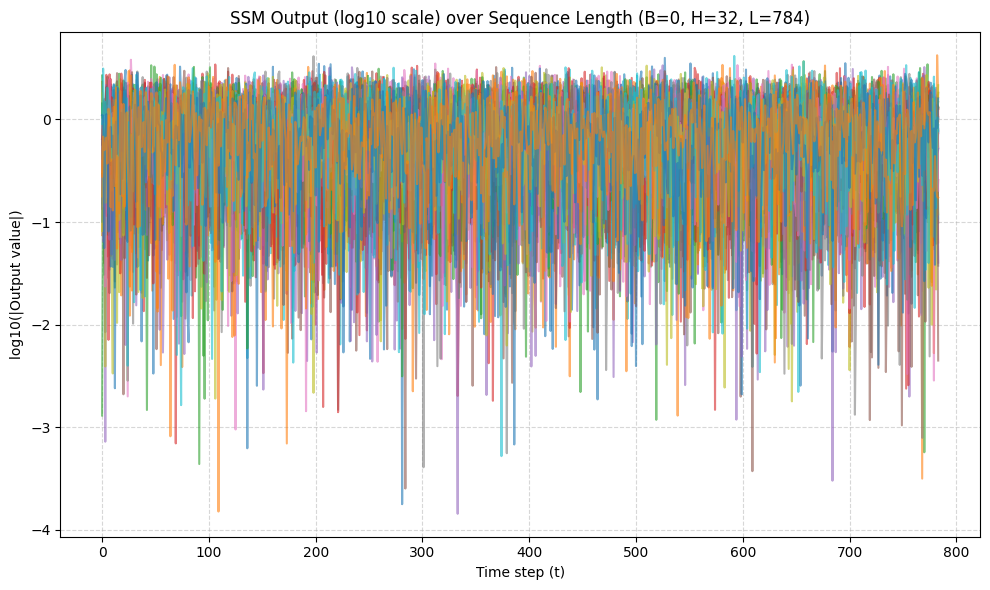

In [25]:
# -------------------------
# Example usage
# -------------------------
B = 2
N = 16
H = 32
L = 784

layer = S4Layer(N=N, H=H, l_max=L, decode=False).to(device)
u = torch.randn(B, L, H).to(device)

# CNN mode
outputs = layer(u)

y = outputs[0].detach().cpu().numpy()
y_abs = np.abs(y) + 1e-8

plt.figure(figsize=(10, 6))
for h in range(H):
    plt.plot(np.log10(y_abs[:, h]), alpha=0.6, label=f'H={h}' if h < 10 else None)

plt.title(f"SSM Output (log10 scale) over Sequence Length (B=0, H={H}, L={L})")
plt.xlabel("Time step (t)")
plt.ylabel("log10(|Output value|)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

We can see that the kernel_DPLR function now takes only 3.1 milliseconds, which is more than 60 times faster than before!
Additionally, our model is now stable, maintaining consistent outputs without exploding values.

We can now wrap this sequence-to-sequence layer with additional functions such as dropour, linear layer transformations and normaliastions:

In [26]:
class SequenceBlock(nn.Module):
    def __init__(self,
                 N: int,
                 H: int,
                 l_max: int,
                 dropout: float = 0.0,
                 glu: bool = True,
                 prenorm: bool = True,
                 decode: bool = False):
        super().__init__()


        self.seq = S4Layer(N=N, H=H, l_max=l_max, decode=decode)
        self.norm = nn.LayerNorm(H)
        self.out = nn.Linear(H, H)
        self.drop = nn.Dropout(dropout)
        self.glu = glu
        self.prenorm = prenorm
        if glu:
            self.out2 = nn.Linear(H, H)

    def forward(self, x):
        """
        x: (B, L, H)
        """
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)               # (B,L,H)
        x = self.drop(F.gelu(x))
        if self.glu:
            x = self.out(x) * torch.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x


# -------------------------
# Example usage
# -------------------------
B = 2
N = 16
H = 32
L = 16

layer = SequenceBlock(N=N, H=H, l_max=L, decode=False).to(device)


u = torch.randn(B, L, H).to(device)
y = layer(u)

print(u.shape)
print(y.shape)

torch.Size([2, 16, 32])
torch.Size([2, 16, 32])


And make entire model that consist of List of SequenceBlocks and Encoder/Decoder transformations to map to and from input dimension. We will use our model for classification, so we can just average outputs over time to remove the sequence length from vector.

In [27]:
class StackedModel(nn.Module):
    def __init__(
        self,
        N: int,
        H: int,
        l_max: int,
        input: int,
        output: int,
        n_layers: int,
        prenorm: bool = True,
        dropout: float = 0.0,
        decode: bool = False,
    ):
        super().__init__()
        self.decode = decode

        self.encoder = nn.Linear(input, H)
        self.decoder = nn.Linear(H, output)

        self.layers = nn.ModuleList([
            SequenceBlock(
                N=N,
                H=H,
                l_max=l_max,
                prenorm=prenorm,
                dropout=dropout,
                decode=decode,
            )
            for _ in range(n_layers)
        ])

    def forward(self, x):
        """
        x: (B, L, D_in) if dense input
           or (B, L) if embedding indices
        """
        x = x / 255.0
        x = self.encoder(x)
        # Run through stacked layers
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=1)  # global average pooling
        x = self.decoder(x)
        return F.log_softmax(x, dim=-1)


# -------------------------
# Example usage
# -------------------------
B = 2
N = 64
H = 128
L = 784
NUM_LAYERS = 4

model = StackedModel(N=64, H=H, l_max=L, input=1, output=10, n_layers=NUM_LAYERS).to(device)


u = torch.randn(B, L, 1).to(device)
y = model(u)

print(u.shape)
print(y.shape)

torch.Size([2, 784, 1])
torch.Size([2, 10])


We will now train our model on the MNIST dataset, where each image is treated as a sequence of pixels.
However, remember that this model can be used just like a Transformer or RNN for any type of sequential data — such as audio, text, or time-series signals!

In [28]:
tf = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5),
            transforms.Lambda(lambda x: x.view(1, 784).t()),
        ]
    )

train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=tf
)
test = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=tf
)

# Return data loaders, with the provided batch size
trainloader = torch.utils.data.DataLoader(
    train, batch_size=128, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test, batch_size=128, shuffle=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.01MB/s]


The final accuracy should reach around 98–99%, but during the first few epochs, it will likely stay near 10% (which corresponds to random predictions).
You can check Weights & Biases (W&B) to see how the training curves should look.

In [ ]:
num_epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),
                       lr = 0.001, weight_decay=0.01)

# Initialize a new W&B run
wandb.init(
        project="lab7-ssm",
        entity="deep-neural-network-course",
        group="s4",
        name="Jan Rosa",                  # change to your name
        # settings=wandb.Settings(save_code=False)
)


# Training loop
for epoch in range(num_epochs):

    #  --------- Training phase -------- #
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics and log to W&B every 100 mini-batches
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            wandb.log({"train/loss": running_loss / 100})
            running_loss = 0.0

    #  --------- Validation phase -------- #
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(testloader)
    accuracy = 100 * correct / total
    print(f'Val Loss: {val_loss:.3f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"val/loss": val_loss, "val/accuracy": accuracy})

print('Finished Training')
wandb.finish()

train/loss,█▄▃▂▂▂▂▂▁▁▁▁
val/accuracy,▁▁▁
val/loss,▂▁█
train/loss,2.30262
val/accuracy,11.35
val/loss,2.3033


[Epoch 1, Batch 100] loss: 2.303
[Epoch 1, Batch 200] loss: 2.302
[Epoch 1, Batch 300] loss: 2.303
[Epoch 1, Batch 400] loss: 2.302
Val Loss: 2.302, Accuracy: 11.35%
[Epoch 2, Batch 100] loss: 2.302
[Epoch 2, Batch 200] loss: 2.301
[Epoch 2, Batch 300] loss: 2.302
[Epoch 2, Batch 400] loss: 2.303
Val Loss: 2.302, Accuracy: 10.10%
[Epoch 3, Batch 100] loss: 2.300
[Epoch 3, Batch 200] loss: 2.221
[Epoch 3, Batch 300] loss: 1.486
[Epoch 3, Batch 400] loss: 1.003
Val Loss: 0.754, Accuracy: 74.13%
[Epoch 4, Batch 100] loss: 0.721
[Epoch 4, Batch 200] loss: 0.662
[Epoch 4, Batch 300] loss: 0.589
[Epoch 4, Batch 400] loss: 0.524
Val Loss: 0.484, Accuracy: 82.44%
[Epoch 5, Batch 100] loss: 0.490
[Epoch 5, Batch 200] loss: 0.459
[Epoch 5, Batch 300] loss: 0.459
[Epoch 5, Batch 400] loss: 0.432
Val Loss: 0.400, Accuracy: 85.61%
[Epoch 6, Batch 100] loss: 0.408
[Epoch 6, Batch 200] loss: 0.401
[Epoch 6, Batch 300] loss: 0.373
[Epoch 6, Batch 400] loss: 0.377
Val Loss: 0.366, Accuracy: 86.82%
[Epo